In [1]:
%load_ext autoreload
%autoreload 2

In [112]:
import time
import random # for torch seed
import os # for torch seed
import pickle
import imageio
import librosa

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import timm

In [3]:
print('timm version', timm.__version__)
print('torch version', torch.__version__)

timm version 0.9.16
torch version 2.3.0


In [4]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### Config

In [5]:
train_dir = Path('E:\data\BirdCLEF')

In [120]:
class CFG:
    DEBUG = False # True False

    # Horizontal melspectrogram resolution
    MELSPEC_H = 128
    # Competition Root Folder
    ROOT_FOLDER = train_dir
    AUDIO_FOLDER = train_dir / 'train_audio'
    DATA_DIR = train_dir / 'spectros'
    TRAN_CSV = train_dir / 'train_metadata.csv'

    num_workers = 4
    # Maximum decibel to clip audio to
    TOP_DB = 100
    # Minimum rating
    MIN_RATING = 3.0
    # Sample rate as provided in competition description
    SR = 32000
    N_FFT = 2048
    HOP_LENGTH = 512

    ### input: not configurable
    IMG_HEIGHT = 28
    IMG_WIDTH = 28
    # N_CLASS = len(np.unique(train['label']))
    
    ### split train and validation sets
    split_fraction = 0.95
    
    ### model
    model_name = 'eca_nfnet_l0' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...  
    
    ### training
    print_freq = 100
    BATCH_SIZE = 256
    N_EPOCHS = 3 if DEBUG else 40
    
    ### set only one to True
    save_best_loss = False
    save_best_accuracy = True
    
    ### optimizer
    #   optimizer = 'adam'
    # optimizer = 'adamw'
    optimizer = 'rmsprop'
    
    LEARNING_RATE = 1e-3
    
    weight_decay = 0.1 # for adamw
    l2_penalty = 0.01 # for RMSprop
    rms_momentum = 0 # for RMSprop
    
    ### learning rate scheduler (LRS)
    scheduler = 'ReduceLROnPlateau'
    #   scheduler = 'CosineAnnealingLR'
    plateau_factor = 0.5
    plateau_patience = 3
    cosine_T_max = 4
    cosine_eta_min = 1e-8
    verbose = True
    
    ### albumentations
    probability = 0.6
    
    random_seed = 42



In [7]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

In [8]:
meta_df = pd.read_csv(CFG.TRAN_CSV)
meta_df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg


In [123]:
sample_submission = pd.read_csv(train_dir / 'sample_submission.csv')

# Set labels
CFG.LABELS = sample_submission.columns[1:]
CFG.N_LABELS = len(CFG.LABELS)
print(f'# labels: {CFG.N_LABELS}')

display(sample_submission.head())

# labels: 182


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


In [10]:
CFG.LABELS

Index(['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2', 'asiope1',
       'aspfly1', 'aspswi1', 'barfly1', 'barswa',
       ...
       'whbwoo2', 'whcbar1', 'whiter2', 'whrmun', 'whtkin2', 'woosan',
       'wynlau1', 'yebbab1', 'yebbul3', 'zitcis1'],
      dtype='object', length=182)

### Load data

In [11]:
def load_pickle(file, flag='rb'):
    with (open(file, "rb")) as openfile:
        while True:
            try:
                return pickle.load(openfile)
            except EOFError:
                break

In [12]:
X = load_pickle(CFG.DATA_DIR / 'X.pkl')
y = load_pickle(CFG.DATA_DIR / 'y.pkl')

In [90]:
filename = meta_df.iloc[0].filename
# filename = 'asbfly/XC164848.ogg'
filename

'asbfly/XC134896.ogg'

C:\Users\Asus\AppData\Local\Temp\ipykernel_29548\1371723265.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  spec = imageio.imread(spec)


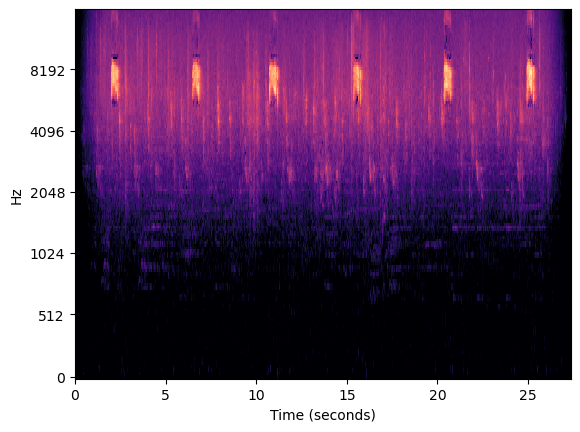

In [91]:
spec = X[filename]
spec = imageio.imread(spec)
librosa.display.specshow(spec, y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

In [80]:
# librosa.times_like(spec, sr=CFG.SR)[:20]

In [81]:
from dataset import spectro_dataset

In [82]:
dset = spectro_dataset(meta_df, X, y)

print(dset.__len__())

spect, label, = dset.__getitem__(1)
print(spect.shape, label.shape)
print(spect.dtype, label.dtype)

24459
asbfly/XC164848.ogg
torch.Size([3, 128, 313]) torch.Size([182])
torch.float32 torch.float32


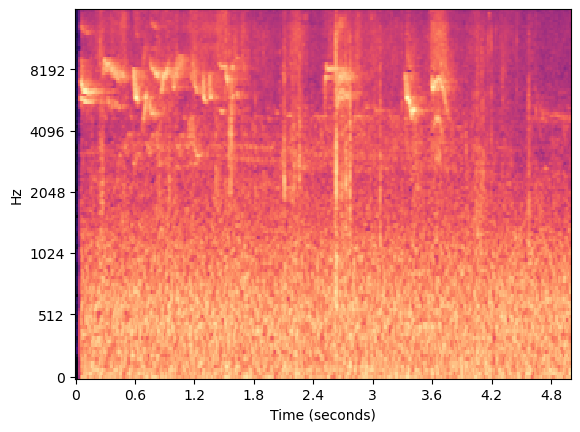

In [88]:
librosa.display.specshow(spect[0].numpy(), y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

### Data Module

In [139]:
class spectro_datamodule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, cfg=CFG):
        super().__init__()
        
        self.train_df = train_df
        self.val_df = val_df
        
        self.train_bs = cfg['BATCH_SIZE']
        self.val_bs = cfg['BATCH_SIZE']
        
        self.num_workers = cfg['num_workers']
        
    def train_dataloader(self):
        train_ds = spectro_dataset(self.train_df, base_dir=cfg['spect_dir'], cols=vote_cols)
        
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=self.train_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=True,
            num_workers=self.num_workers,
        )
        
        return train_loader
        
    def val_dataloader(self):
        val_ds = spectro_dataset(self.val_df, base_dir=cfg['spect_dir'], cols=vote_cols)
        
        val_loader = torch.utils.data.DataLoader(
            val_ds,
            batch_size=self.val_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        
        return val_loader

NameError: name 'cfg' is not defined

### Loss function

In [94]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss

In [93]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x

### Model

In [92]:
print('Number of models available: ', len(timm.list_models(pretrained=True)))
print('Number of models available: ', len(timm.list_models()))
# print('\nDensenet models: ', timm.list_models('eff*'))

Number of models available:  1329
Number of models available:  1032


In [125]:
backbone = 'eca_nfnet_l0'
# backbone = 'efficientnet_b4'
out_indices = (3, 4)

In [126]:
model = timm.create_model(
    backbone,
    features_only=True,
    pretrained=False,
    in_chans=3,
    num_classes=5,
    out_indices=out_indices,
    )

In [103]:
# model.feature_info.

In [104]:
model.feature_info.channels()

[64, 256, 512, 1536, 2304]

In [97]:
model.feature_info.channels()

[16, 24, 40, 112, 320]

In [62]:
np.sum(model.feature_info.channels())

432

In [63]:
spect.shape

torch.Size([3, 128, 988])

In [64]:
foo = model(spect.unsqueeze(0))
len(foo)

2

In [65]:
foo[0].shape, foo[1].shape

(torch.Size([1, 112, 8, 62]), torch.Size([1, 320, 4, 31]))

In [137]:
class GeMModel(pl.LightningModule):
    def __init__(self, cfg = CFG, pretrained = True):
        super().__init__()

        self.cfg = cfg
        
        out_indices = (3, 4)

        self.criterion = FocalLossBCE()

        # self.model_name = self.cfg.model_name
        print(self.cfg.model_name)
        
        self.backbone = timm.create_model(
            self.cfg.model_name, 
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=self.cfg.N_LABELS,
            out_indices=out_indices,
        )

        feature_dims = self.backbone.feature_info.channels()

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.head = torch.nn.Linear(self.mid_features, self.cfg.N_LABELS)

    def forward(self, x):
        ms = self.backbone(x)
        
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.head(x)
        
        return x
        
    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr=cfg['lr'], weight_decay=0.015)

    def step(self, batch, batch_idx, mode='train'):
        x, y = batch
        
        preds = self(x)
        
        loss = self.criterion(preds, y)

        # kl_loss = self.kl_loss(F.log_softmax(preds, dim=1), y)
        # loss = kl_loss
        
        if mode == 'train':
            self.train_acc(preds, y.argmax(1))
        else:
            self.val_acc(preds, y.argmax(1))
        
        self.log(f'{mode}/loss', loss, on_step=True, on_epoch=True)
        self.log(f'{mode}/kl_loss', kl_loss, on_step=True, on_epoch=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='train')
        self.log(f'train/acc', self.train_acc, on_step=True, on_epoch=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss =  self.step(batch, batch_idx, mode='val')
        self.log(f'val/acc', self.val_acc, on_step=True, on_epoch=True)
    
        return loss
    
    def on_train_epoch_end(self):
        self.train_acc.reset()
        self.val_acc.reset()


In [138]:
model = GeMModel(CFG)

eca_nfnet_l0


### Train